# **AI61002 DLFA**
# **Bengali Digit Recognition Project**
##    **-Divyanshu Sheth, 18QE30008**

The tried and tested architecture for digit recognition, LeNet, has been used for this project. The final test accuracy obtained is 94.2857%, with the final F1-score on the test set being 0.9368. The model was trained over 120 epochs over the dataset, which had 1393 images with their corresponding ground-truth labels. 

1. >The dataset was spilt as follows: **70% train set, 15% validation set and 15% test set**. This amounts to 974 images for training and about 210 images for validation and testing.

2. 
>Yes:
i) A **manual rescaling weight** has been given to each class while defining the **loss function**. This ensures that the model will be largely penalised if it wrongly classifies images belonging to minority classes. The **weights assigned to the classes are the inverse of their corresponding image counts** in the dataset, which results in minority classes being given high weights and majority classes relatively low weights.
ii) **F1-score** has been chosen as the **primary evaluation metric**. The model was trained until a favourable outcome for F1-score on validation data was observed. Also, results on the test set have been presented as F1-score values.

3. >Yes, **Cosine Annealing with Warm Restarts** has been incorporated in the model.

4. >Training and validation curves have been **plotted towards the end of the notebook**. For deciding on when to stop training the model, it was **run over 200 epochs**, taking **validation results on after every epoch**; what was observed was that training and validation accuracy curves reach saturation and then the validation curve (based on F1-score and accuracy) gradually starts dipping after about 120 epochs of training. Thus, when the **validation loss** was observed to be **minimum**, i.e. maximum validation accuracy/F1-score, training was stopped.

5. >The total number of parameters in the model is 62006. The space taken up by the model is 1984 kilobytes. 


In [0]:
# Please change xls_file_location to the file location of the xls file containing ground-truth labels for the images,
# and root_dir_location to the location of the folder containing all images in the dataset. 

xls_file_location = '/content/drive/My Drive/AI Work/BDRW Project/datasets/dataset_provided/labels/labels.xls'
root_dir_location = '/content/drive/My Drive/AI Work/BDRW Project/datasets/dataset_provided/images'

In [29]:
# Imports for essential libraries:

%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset  
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import PIL
from PIL import Image

torch.manual_seed(42)

In [0]:
# Images are resized to 32 x 32 before passing in the model. Data Augmentation has been done to improve the robustness of the model. 
# Random rotations by +/- 15 degrees, random color jitters and random conversion to grayscale images have been done.
# Also, images have been normalized to enable better convergence while training.

data_transform = transforms.Compose([transforms.Resize((32, 32), interpolation = PIL.Image.BILINEAR),
                                     transforms.RandomRotation(degrees=(-15, 15)),
                                     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                     transforms.RandomGrayscale(p=0.1),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
# The class for the provided dataset is defined here. 
# __len__ returns the length of the dataset and __getitem__ returns an image and its corresponding label.

class BDRWDataset(Dataset):
    def __init__(self, xls_file, root_dir, transform = data_transform):
        """
        Args:
            csv_file (string): Path to the xls file with ground truth labels.
            root_dir (string): Directory with all the images.
        """
        self.xls_file = pd.read_excel(xls_file) 
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.xls_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = Image.open(os.path.join(self.root_dir, (self.xls_file.iloc[idx, 0]) + '.jpg'))
        digit_label = self.xls_file.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        return (image, digit_label)

In [0]:
# We define and build the datasets and DataLoaders for training, validation and test sets.

dataset = BDRWDataset(xls_file = xls_file_location,
                      root_dir = root_dir_location)

batch_size = 256

# The dataset has been split into 70% train, 15% validation, and 15% test sets.

validation_split = 0.15
test_split = 0.15     

# Calculating the sizes of the datasets, and randomly splitting the data into the three sets:

train_size = int((1 - test_split - validation_split) * len(dataset))
validation_size = (int)(validation_split * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

# Defining train, validation and test DataLoaders:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)

In [33]:
print('Train set size = ' + str(len(train_loader.dataset)))
print('Validation set size = ' + str(len(validation_dataset)))
print('Test set size = ' + str(len(test_loader.dataset)))

Train set size = 974
Validation set size = 208
Test set size = 210


In [0]:
# Defining the architecture of the model (LeNet):

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [35]:
# Declaring 'net' as an object of the LeNet class, checking for GPU availability, and printing out the defined model:

net = LeNet()
if torch.cuda.is_available():
  !nvidia-smi -L
  net = net.cuda()
print('\n', net)

GPU 0: Tesla K80 (UUID: GPU-c80717fb-5cde-7651-787e-40427c135942)

 LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [50]:
# Total number of parameters in the model:

pytorch_total_params = sum(p.numel() for p in net.parameters())
print('Total parameters = ' + str(pytorch_total_params))

# for space taken up by the model, we multiply this by the size of each parameter.

Total parameters = 62006


In [0]:
# Class sample counts are the frequencies of occurence of classes at the corresponding locations. 
# There are 166 images of digit 0, 281 for digit 1, and so on, in the dataset.
# The weights is declared to be the inverse of image counts by class. 
# These weights, which will be passed in the loss function, will result in giving higher importance to minority classes while calculating loss.

class_sample_counts = [166, 281, 211, 133, 124, 126, 98, 89, 83, 81]
weights_temp = [1 / csc for csc in class_sample_counts]

weights = torch.Tensor(weights_temp)
if torch.cuda.is_available():
  weights = weights.cuda()

In [37]:
learning_rate = 0.01

# Loss function defined as Binary Cross Entropy Loss:

criterion = nn.CrossEntropyLoss(weight = weights) 

# Adaptive Momentum (Adam) is used as optimizer:

optimizer = optim.Adam(net.parameters(), lr = learning_rate)

# Cosine Annealing with Warm Restarts has been used:

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult=1, eta_min=0, last_epoch=-1)

# The number of epochs was chosen after analysing the training and validation curves for 200 epochs, as stated in the beginning.

num_epochs = 120

# Lists defined to keep track of values at each epoch, for plotting graphs later:

train_loss = []
train_accuracy = []
validation_accuracy = []
f1_scores = []

for epoch in range(num_epochs):
    
    running_loss = 0.0 
    running_corr = 0
    
    for i,data in enumerate(train_loader):
        
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda() 
        labels = labels.long()
        
        # Initializing model gradients to zero
        
        net.zero_grad() 
        
        # Data feed-forward through the network
        
        outputs = net(inputs)
        
        # Predicted class is the one with maximum probability
        
        preds = torch.argmax(outputs,dim=1)

        # Finding the loss

        loss = criterion(outputs, labels)
        
        # Accumulating the loss for each batch
        
        running_loss += loss 
        
        # Accumulate number of correct predictions
        
        running_corr += torch.sum(preds==labels)    
       
    totalLoss = running_loss/(i+1)
    
    # Calculating gradients
    
    totalLoss.backward()
    
    # Updating the model parameters
    
    optimizer.step()

    # Scheduler step for warm restart:

    scheduler.step(epoch + i / len(train_loader))
        
    epoch_loss = running_loss.item()/(i+1)                #Total loss for one epoch
    epoch_acc = running_corr.item()/len(train_dataset)
         
    train_loss.append(epoch_loss)                         #Saving the loss over epochs for plotting the graph
    train_accuracy.append(epoch_acc)                      #Saving the accuracy over epochs for plotting the graph
      
    correct_pred = 0
    f1 = 0

    # Evaluating performance on the validation set:

    for data in validation_loader:
        inputs,labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(),labels.cuda()
        
        # Feedforward train data batch through model
        output = net(inputs) 
        
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        
        correct_pred += torch.sum(preds==labels)
        
        labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
        
        # Determining the F1-Score on validation data:

        f1 = f1_score(labels, preds, average = 'macro')
    
    # Calculating validation accuracy, appending to lists

    validation_acc = correct_pred.item()/len(validation_loader.dataset)
    validation_accuracy.append(validation_acc)
    f1_scores.append(f1)
    
    print('Epoch {:.0f}/{:.0f}:\n Training loss: {:.4f} | Training Accuracy: {:.4f} | Validation Accuracy: {:.4f} | Validation F1 Score: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc*100, validation_acc * 100, f1))

Epoch 1/120:
 Training loss: 2.3056 | Training Accuracy: 17.5565 | Validation Accuracy: 7.2115 | Validation F1 Score: 0.0135
Epoch 2/120:
 Training loss: 2.3006 | Training Accuracy: 9.5483 | Validation Accuracy: 9.6154 | Validation F1 Score: 0.0496
Epoch 3/120:
 Training loss: 2.2753 | Training Accuracy: 10.7803 | Validation Accuracy: 19.7115 | Validation F1 Score: 0.1444
Epoch 4/120:
 Training loss: 2.1895 | Training Accuracy: 24.2300 | Validation Accuracy: 23.5577 | Validation F1 Score: 0.1718
Epoch 5/120:
 Training loss: 2.0826 | Training Accuracy: 28.8501 | Validation Accuracy: 18.2692 | Validation F1 Score: 0.1462
Epoch 6/120:
 Training loss: 2.0506 | Training Accuracy: 21.9713 | Validation Accuracy: 44.7115 | Validation F1 Score: 0.3866
Epoch 7/120:
 Training loss: 1.8187 | Training Accuracy: 48.1520 | Validation Accuracy: 47.1154 | Validation F1 Score: 0.3984
Epoch 8/120:
 Training loss: 1.7881 | Training Accuracy: 47.7413 | Validation Accuracy: 47.1154 | Validation F1 Score: 0.

Text(0, 0.5, 'Validation F1 Score')

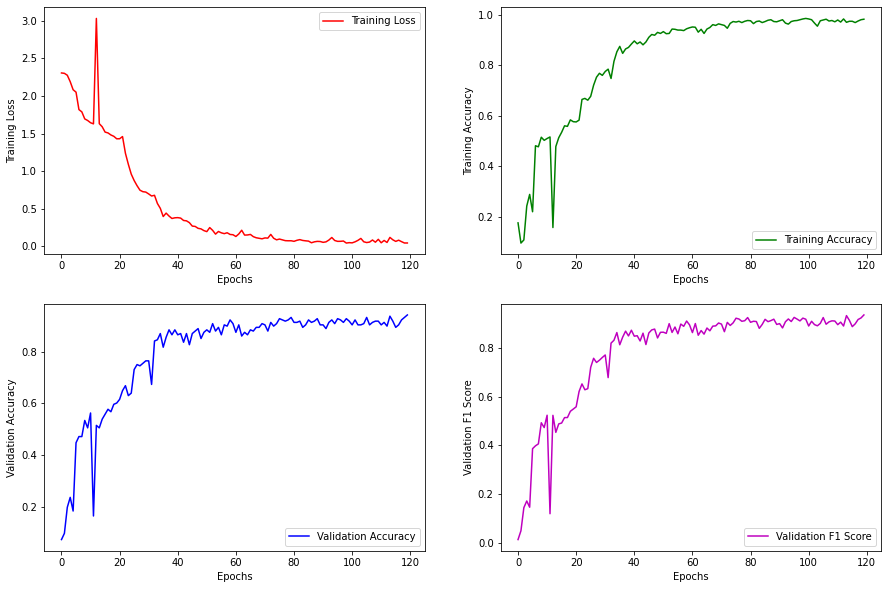

In [38]:
# Plotting graphs - Training Loss, Training Accuracy, Validation accuracy, Validation F-1 score:

fig = plt.figure(figsize=[15,10]) 

plt.subplot(221)
plt.plot(range(num_epochs), train_loss,'r-',label = 'Training Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.subplot(222)
plt.plot(range(num_epochs), train_accuracy,'g-',label = 'Training Accuracy') 
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

plt.subplot(223)
plt.plot(range(num_epochs), validation_accuracy, 'b-', label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.subplot(224)
plt.plot(range(num_epochs), f1_scores, 'm-', label = 'Validation F1 Score')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation F1 Score')

In [40]:
# Evaluating results on the test set:

correct_pred = 0
f1 = 0
for data in test_loader:
    inputs,labels = data
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()
    
    output = net(inputs) 
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)
    
    labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
    f1 = f1_score(labels, preds, average = 'macro')

test_accuracy = correct_pred.item()/len(test_loader.dataset)
print('Testing accuracy = ' +  str(test_accuracy*100) + ' | ' + 'F1-Score = ' + str(f1))

Testing accuracy = 94.28571428571428 | F1-Score = 0.9368948660888557
